# Brayton Cycle

In [354]:
import eosHSG as eos
import scipy, scipy.optimize, scipy.interpolate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [355]:
nitrogen = eos.getCompound('Nitrogen', 'pr')
oxygen = eos.getCompound('Oxygen', 'pr')
methane = eos.getCompound('Methane', 'pr')
carbondioxide = eos.getCompound(('Carbon dioxide'), 'pr')
water = eos.getCompound('Water', 'pr')

dict_comps = {'n2':nitrogen, 'o2':oxygen,
             'ch4':methane, 'co2':carbondioxide,
             'h2o':water}

In [356]:
class Mixture:
    def __init__(self):
        self.dict_flows = {}
        self.T = 300.0
        self.P = 1.013e5
    
    def setProps(self):
        
        F = sum([self.dict_flows[comp] for comp in self.dict_flows])
        Hmix = 0.0
        Smix = 0.0
        
        for name in dict_comps:
            comp = dict_comps[name]
            Fcomp = self.dict_flows[name]
            x = Fcomp/F
            
            if x > 0.0:
                Z = comp.Z(self.T, self.P*x)[-1]
                h = comp.H(self.T, self.P*x, Z)
                s = comp.S(self.T, self.P*x, Z)
                
                Hmix += Fcomp*h
                Smix += Fcomp*s
                
        self.H = Hmix
        self.S = Smix
        
    def copy(self, mix):
        self.T = mix.T + 0.0
        self.P = mix.P + 0.0
        for name in mix.dict_flows:
            self.dict_flows[name] = mix.dict_flows[name] + 0.0
        self.setProps()

In [357]:
Fair = 1.0 #kmol/s
Tamb = 300 #K
Pamb = 1.013e5 #Pa
Pcomp = 10e5 #Pa
efficiency = 0.6
frexcessair = 1.2

air = Mixture()
air.T = Tamb
air.P = Pamb
air.dict_flows = {   'n2': 0.79*Fair,
                     'o2': 0.21*Fair,
                     'ch4': 0.0,
                     'co2': 0.0,
                     'h2o': 0.0
                 }
air.setProps()

In [358]:
def residualS(T, Starget, mixture):
    mixture.T = T
    mixture.setProps()
    return Starget - mixture.S

def isentropic(mixture, Pfinal):
    compmix = Mixture()
    compmix.copy(mixture)
    compmix.P = Pfinal
    Starget = mixture.S
    T = scipy.optimize.newton(residualS, mixture.T + 0.0, args = (Starget, compmix))
    compmix.T = T
    compmix.setProps()
    return compmix

def residualH(T, Htarget, mixture):
    mixture.T = T
    mixture.setProps()
    return Htarget - mixture.H

def heat(mixture, Htarget):
    hotmix = Mixture()
    hotmix.copy(mixture)
    T = scipy.optimize.newton(residualH, mixture.T + 0.0, args = (Htarget, hotmix))
    hotmix.T = T
    
    hotmix.setProps()
    return hotmix

def cool(mixture, Tfinal):
    coolmix = Mixture()
    coolmix.copy(mixture)
    coolmix.T = Tfinal
    coolmix.setProps()
    return coolmix

In [359]:
compair = isentropic(air, Pcomp)
IdealWork = compair.H - air.H
ActualWork = IdealWork/efficiency
Hdissipated = ActualWork - IdealWork
compair = heat(compair, compair.H + Hdissipated)

fuel = Mixture()
fuel.T = Tamb
fuel.P = Pcomp
fuel.dict_flows = {
                    'n2': 0.0,
                    'o2': 0.0,
                    'ch4': 0.21*Fair/((1+frexcessair)*2),
                    'co2': 0.0,
                    'h2o': 0.0
                }
fuel.setProps()

In [361]:
def mix(stream1, stream2):
    newstream = Mixture()
    for name in stream1.dict_flows:
        newstream.dict_flows[name] = stream1.dict_flows[name] + stream2.dict_flows[name]
        
    newstream.H = stream1.H + stream2.H
    newstream.P = min([stream1.P, stream2.P])
    newstream = heat(newstream, newstream.H)
    return newstream

famix = mix(compair, fuel)

In [362]:
def combust(mixture):
    combmix = Mixture()
    Hcomb = mixture.H
    Scomb = mixture.S
    combmix.copy(mixture)
    combmix.dict_flows['ch4'] = mixture.dict_flows['ch4']*0.0
    combmix.dict_flows['co2'] = mixture.dict_flows['co2'] + mixture.dict_flows['ch4']
    combmix.dict_flows['o2'] = mixture.dict_flows['o2'] - 2*mixture.dict_flows['ch4']
    combmix.dict_flows['h2o'] = mixture.dict_flows['h2o'] + 2*mixture.dict_flows['ch4']
    
    combmix = heat(combmix, Hcomb)
    return combmix

combustion = combust(famix)

In [364]:
Ffuel = fuel.dict_flows['ch4']
Fn2 = 0.79*Fair
Fo2 = 0.21*Fair - 2*Ffuel
Fch4 = 0.0
Fco2 = Ffuel
Fh2o = 2*Ffuel

Ftotal = Fn2+Fo2+Fch4+Fco2+Fh2o
x_n2 = Fn2/Ftotal
x_o2 = Fo2/Ftotal
x_ch4 = Fch4/Ftotal
x_co2 = Fco2/Ftotal
x_h2o = Fh2o/Ftotal

df1 = pd.DataFrame({"Components":["N2","O2","CH4","CO2","H2O"],
                    "Mole Fraction in Exhaust Gas": [x_n2,x_o2,x_ch4,x_co2,x_h2o]})

In [365]:
gases = Mixture()
gases.T = combustion.T
gases.P = combustion.P
gases.dict_flows = {'n2':Fn2,'o2':Fo2,'ch4':Fch4,'co2':Fco2,'h2o':Fh2o}
gases.setProps()

exhaustgas = isentropic(gases, Pamb)
Ideal_Work = gases.H - exhaustgas.H
Actual_Work = Ideal_Work*efficiency
Hreleased = Ideal_Work - Actual_Work
exhaustgas = heat(exhaustgas, exhaustgas.H + Hreleased)
cooledgases = cool(gases, compair.T)

In [367]:
df = pd.DataFrame({ "Temperature":[air.T, compair.T, fuel.T, famix.T, combustion.T, exhaustgas.T],
                    "Pressure":[air.P, compair.P, fuel.P, famix.P, combustion.P, exhaustgas.P],
                    "Enthalpy":[air.H, compair.H, fuel.H, famix.H, combustion.H, exhaustgas.H],
                    "Entropy":[air.S, compair.S, fuel.S, famix.S, combustion.S, exhaustgas.S]},
                 index = ["Air","Compressed Air", "Fuel", "Mixture", "Combustion", "Exhaust Gas"])
df

,Temperature,Pressure,Enthalpy,Entropy
Air,300.000000,101300.0,4.874745e+04,4331.322307
Compressed Air,744.255394,1000000.0,1.344766e+07,12520.150199
Fuel,300.000000,1000000.0,-3.562096e+06,-4769.933375
Mixture,714.421288,1000000.0,9.885568e+06,9974.264770
Combustion,1733.461053,1000000.0,9.885568e+06,44054.623983
Exhaust Gas,1318.308394,101300.0,-6.347416e+06,53313.240220


In [368]:
Qin = gases.H - cooledgases.H
OverallEfficiency = ((Actual_Work-ActualWork)/Qin)*100
OverallEfficiency1 = (1-(compair.T/exhaustgas.T))*100

In [370]:
df2 = pd.DataFrame({ "Temperature":[air.T, compair.T, combustion.T, exhaustgas.T],
                    "Pressure":[air.P, compair.P, combustion.P, exhaustgas.P],
                    "Enthalpy":[air.H, compair.H, combustion.H, exhaustgas.H],
                    "Entropy":[air.S, compair.S, combustion.S, exhaustgas.S]},
                 index = ["Inlet Air","Stage 1: Compressed Air", "Stage 2: Combusted Fuel", "Stage 3: Exhaust Gas"])

In [371]:
df1

,Components,Mole Fraction in Exhaust Gas
0,N2,0.754013
1,O2,0.109328
2,CH4,0.000000
3,CO2,0.045553
4,H2O,0.091106


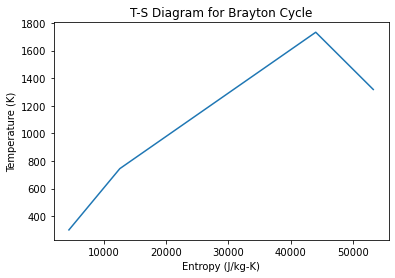

Overall Efficiency of the Brayton Cycle is 7.625 %


In [372]:
plt.plot(df2["Entropy"],df2["Temperature"])
plt.title('T-S Diagram for Brayton Cycle')
plt.xlabel('Entropy (J/kg-K)')
plt.ylabel('Temperature (K)')
plt.show()
print("Overall Efficiency of the Brayton Cycle is %.3f" %(OverallEfficiency), "%")